In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
from keras import regularizers ### for SVM
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
os.environ['PYTHONASHSEED']= '0'
from keras.models import load_model

tf.reset_default_graph()

Using TensorFlow backend.


In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(7)
#seting the seed for python random numbers
rn.seed(124)
#seting the seed for tensorflow random numbers
tf.set_random_seed(57)

In [4]:
import os
classes_name = []
files_name = []
for root, dirs, files in os.walk('Dataset1/train_data'):  
    for name in dirs:
        classes_name.append(name)
    for name1 in files:
        files_name.append(name1)

print(len(classes_name))


2


In [5]:
##### calculate  number of images
import os
classes_name_train = []
files_name_train = []
classes_name_test = []
files_name_test = []
for root, dirs, files in os.walk('Dataset1/train_data'):  
    for name in dirs:
        classes_name_train.append(name)
    for name1 in files:
        files_name_train.append(name1)
        
for root, dirs, files in os.walk('Dataset1/test_data'):  
    for name in dirs:
        classes_name_test.append(name)
    for name1 in files:
        files_name_test.append(name1)

no_training = len(files_name_train)
no_testing = len(files_name_test)
        
print(len(classes_name_train))
print(len(files_name_train))
print(len(classes_name_test))
print(len(files_name_test))
number_classes = len(classes_name_train)

2
321
2
79


In [6]:
batch_size = 8
n_epochs = 500

In [7]:
train_path = 'Dataset1/train_data'
test_path = 'Dataset1/test_data'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = classes_name, batch_size = batch_size)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = classes_name, batch_size = batch_size)


Found 321 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [8]:
# plots images with labels  within jupyter notebook

def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()

In [9]:
imgs, labels = next(train_batches)


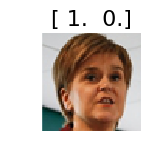

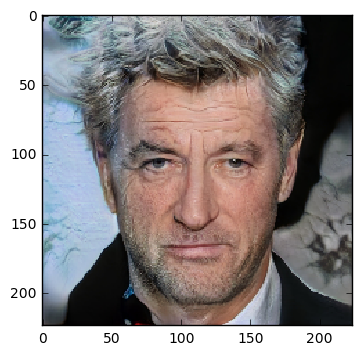

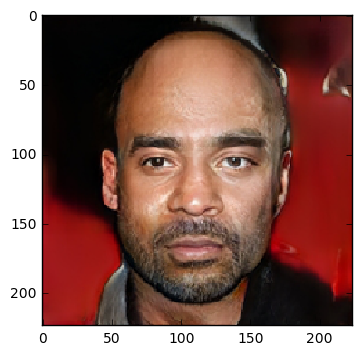

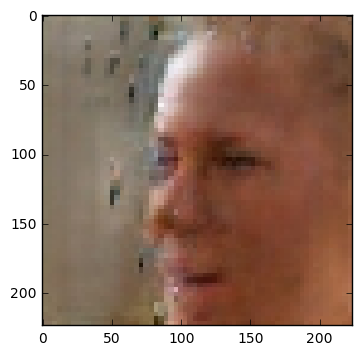

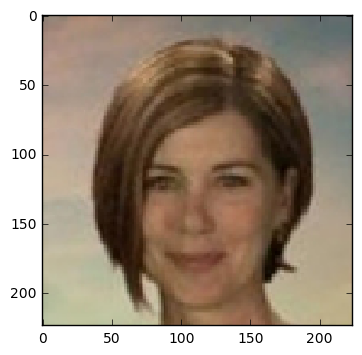

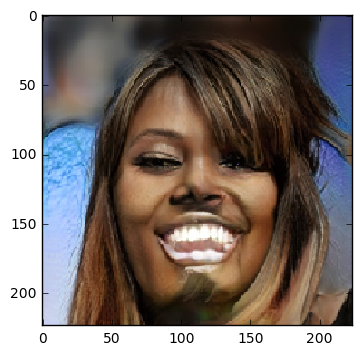

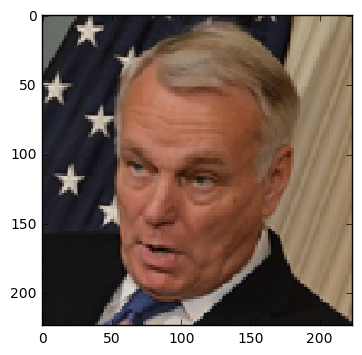

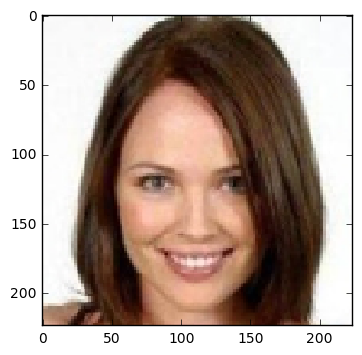

In [11]:
plots(imgs, titles = labels)

In [12]:
# ####  Build Fine-tuned ResNet model
# model = keras.applications.resnet50.ResNet50()
# print('Model loaded.')
# model.summary()


Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________________

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [20]:
for indx, ly in enumerate(model.layers):
    print(ly.name + ' - ' + str(indx))

input_1 - 0
conv1_pad - 1
conv1 - 2
bn_conv1 - 3
activation_1 - 4
max_pooling2d_1 - 5
res2a_branch2a - 6
bn2a_branch2a - 7
activation_2 - 8
res2a_branch2b - 9
bn2a_branch2b - 10
activation_3 - 11
res2a_branch2c - 12
res2a_branch1 - 13
bn2a_branch2c - 14
bn2a_branch1 - 15
add_1 - 16
activation_4 - 17
res2b_branch2a - 18
bn2b_branch2a - 19
activation_5 - 20
res2b_branch2b - 21
bn2b_branch2b - 22
activation_6 - 23
res2b_branch2c - 24
bn2b_branch2c - 25
add_2 - 26
activation_7 - 27
res2c_branch2a - 28
bn2c_branch2a - 29
activation_8 - 30
res2c_branch2b - 31
bn2c_branch2b - 32
activation_9 - 33
res2c_branch2c - 34
bn2c_branch2c - 35
add_3 - 36
activation_10 - 37
res3a_branch2a - 38
bn3a_branch2a - 39
activation_11 - 40
res3a_branch2b - 41
bn3a_branch2b - 42
activation_12 - 43
res3a_branch2c - 44
res3a_branch1 - 45
bn3a_branch2c - 46
bn3a_branch1 - 47
add_4 - 48
activation_13 - 49
res3b_branch2a - 50
bn3b_branch2a - 51
activation_14 - 52
res3b_branch2b - 53
bn3b_branch2b - 54
activation_15 -

In [21]:
model.layers[175].output

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [17]:
img_rows = 224
img_cols = 224
n_channels = 3

### 
input_of_stream = Input(shape=(img_rows, img_cols, n_channels))



feature_mode2 = model.predict(input_of_stream)


AttributeError: 'Tensor' object has no attribute 'ndim'

In [ ]:
model.layers.pop()


In [ ]:
last = model.layers[-1].output
x = Dense(2, activation = 'linear', kernel_regularizer=regularizers.l2(0.001))(last)
finetuned_model = Model(model.input, x)


In [ ]:
n = len(finetuned_model.layers)
for idx, layer in enumerate(finetuned_model.layers):
    if idx < (n-1): 
           layer.trainable = False   
    else:
           layer.trainable = True   
          

In [ ]:
opt = Adam(lr=0.0001, decay=10e-6)
finetuned_model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])

# model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='hinge', optimizer=sgd, metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "weights.resnet50.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = finetuned_model.fit_generator(train_batches, steps_per_epoch = 120, validation_data = valid_batches, validation_steps=26, epochs =200, shuffle=True, callbacks = callbacks_list, verbose =2)

In [ ]:

# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()

In [ ]:
# Save model 
#model.save('forgecy_image_model.h5')
# model.summary()
# model.get_weights()
# model.optimizer
## Load  model 
#from keras.models import load_model 
#model = load_model('forgecy_image_model.h5')


In [ ]:
# # estimate accuracy on whole dataset using loaded weights
# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:, 0]
predictions = finetuned_model.predict_generator(test_batches, steps =1 , verbose = 0)
predictions
test_batches.class_indices
# rounded _predictions = model.predict_generator_classes(test_batches, steps =1 , verbose = 0)

In [ ]:
cm = confusion_matrix(test_lables, np.round(predictions[:,0]))
cm_plot_labels = ['Au', 'Sp']
plot_confusion_matix(cm, cm_plot_labels, title = 'confusion Matrix')